In [1]:
import numpy as np 
import pandas as pd 


import os
print(os.listdir("./kvasir-dataset-v2/"))

['normal-z-line', 'esophagitis', 'normal-pylorus', 'normal-cecum', 'dyed-lifted-polyps', 'polyps', 'dyed-resection-margins', 'ulcerative-colitis']


In [3]:
import cv2
import glob
import keras
from keras.utils import np_utils
from keras.models import Sequential , Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop, Nadam

from keras.utils import to_categorical
from matplotlib import pyplot
from keras.layers import  Dropout, BatchNormalization , Activation , Input
from keras.regularizers import l1,l2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import cv2
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [4]:
path = "./kvasir-dataset-v2/"
categories = next(os.walk(path))[1]
X , Y = [] , []
count = 0
for category in categories:
    ids = next(os.walk(path + category))[2]
    for i in ids:
        img = cv2.imread(path + category + '/' + i)
        img_resized = cv2.resize(img,(128,128), interpolation=cv2.INTER_AREA)
        img_rsd_normalized = img_resized / 255.0
        X.append(img_rsd_normalized)
        Y.append(count)
    count += 1 

In [5]:
print(categories)

['normal-z-line', 'esophagitis', 'normal-pylorus', 'normal-cecum', 'dyed-lifted-polyps', 'polyps', 'dyed-resection-margins', 'ulcerative-colitis']


In [6]:
X , Y = np.array(X) , np.array(Y)
Y = np_utils.to_categorical(Y)
print(X.shape , Y.shape)

(8000, 128, 128, 3) (8000, 8)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(X_train.shape , X_val.shape , X_test.shape)

(5760, 128, 128, 3) (1440, 128, 128, 3) (800, 128, 128, 3)


In [8]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
TRAIN_DIR = './kvasir-dataset-v2'

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=10,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)
val_datagen.fit(X_val)
test_datagen.fit(X_test)

In [9]:
def create_model(input_shape, n_out):
    
    pretrain_model = VGG19(
        include_top=False, 
        weights=None, 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(n_out, activation='softmax')(x)
    model = Model(input_tensor, output)
    
    return model
model = create_model((128,128,3),8)
model.compile(optimizer=Adam(lr=2e-5,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 128)         65664     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104

In [10]:
# Defining some Callbacks
import math
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import numpy as np



weight_path="{}_weights_mymodel_vgg19_AdamOpt.hdf5".format('mykaggle')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = True)

checkpoint = ModelCheckpoint(weight_path, verbose=2, monitor='val_loss',save_best_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, verbose=1, mode='min', min_delta=0.0001, cooldown=5, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss",  mode="min",   patience=12) 
callbacks_list = [reduceLROnPlat,early,checkpoint]


history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), validation_data=(X_val,y_val),
                    steps_per_epoch=len(X_train) / BATCH_SIZE, epochs=50 , callbacks=callbacks_list)

Epoch 1/50
360/360 [==============================] - 116s 323ms/step - loss: 1.3776 - accuracy: 0.4035 - val_loss: 0.9796 - val_accuracy: 0.5167

Epoch 00001: val_loss improved from inf to 0.97960, saving model to mykaggle_weights_mymodel_vgg19_AdamOpt.hdf5
Epoch 2/50
360/360 [==============================] - 105s 292ms/step - loss: 0.9522 - accuracy: 0.5689 - val_loss: 0.7965 - val_accuracy: 0.6257

Epoch 00002: val_loss improved from 0.97960 to 0.79649, saving model to mykaggle_weights_mymodel_vgg19_AdamOpt.hdf5
Epoch 3/50
360/360 [==============================] - 104s 289ms/step - loss: 0.8849 - accuracy: 0.6087 - val_loss: 0.8030 - val_accuracy: 0.6083

Epoch 00003: val_loss did not improve from 0.79649
Epoch 4/50
360/360 [==============================] - 104s 289ms/step - loss: 0.8309 - accuracy: 0.6236 - val_loss: 0.7418 - val_accuracy: 0.6729

Epoch 00004: val_loss improved from 0.79649 to 0.74184, saving model to mykaggle_weights_mymodel_vgg19_AdamOpt.hdf5
Epoch 5/50
360/36

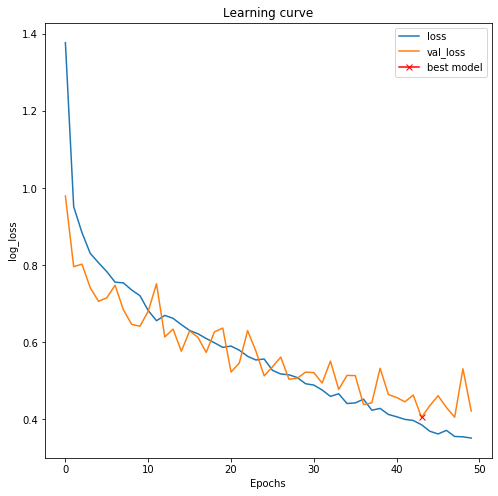

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model.history.history["val_loss"]), np.min(model.history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [12]:
pred = model.predict(X_test,verbose=1)
print(len(pred))

800/800 [==============================] - 5s 7ms/step
800


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
# to_categorical(np.argmax(pred, axis=1))
def decode(datum):
    return np.argmax(datum)

mybatchlabels = []
for i in range(len(X_test)):
  mybatchlabels.append(decode(y_test[i]))

y_pred = np.argmax(pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(X_test, mybatchlabels))
print('Classification Report')
target_names = ['normal-pylorus', 'normal-z-line', 'dyed-resection-margins', 'ulcerative-colitis', 'dyed-lifted-polyps', 'normal-cecum', 'esophagitis', 'polyps']
print(classification_report(mybatchlabels, y_pred, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

        normal-pylorus       0.67      0.93      0.78        86
         normal-z-line       0.87      0.54      0.67        89
dyed-resection-margins       0.95      0.96      0.95        99
    ulcerative-colitis       0.85      0.94      0.90        87
    dyed-lifted-polyps       0.83      0.78      0.81       115
          normal-cecum       0.81      0.82      0.81       110
           esophagitis       0.80      0.86      0.83       117
                polyps       0.88      0.76      0.82        97

              accuracy                           0.82       800
             macro avg       0.83      0.82      0.82       800
          weighted avg       0.83      0.82      0.82       800

